In [1]:
import marlin as mar

In [2]:
handler_1 = mar.handlerCore()

In [3]:
handler_1.connect()

Connected.


In [4]:
handler_1.set_valve_state("PFA(half-MeAc)",0)

[0,1,1,9,0];0;0


In [5]:
handler_1.set_pump_state(0)

[0,1,1,9,0];0;0


In [6]:
Ti5 = mar.scopeCore("./MMMain.cfg","./logfile.txt",camera_name="BSI Prime",shutter_name="SpectraIII",xystage_name="XYStage",focus_name="ZDrive")

In [19]:
Ti5.mmc.setConfig("FISH_channels","BF")

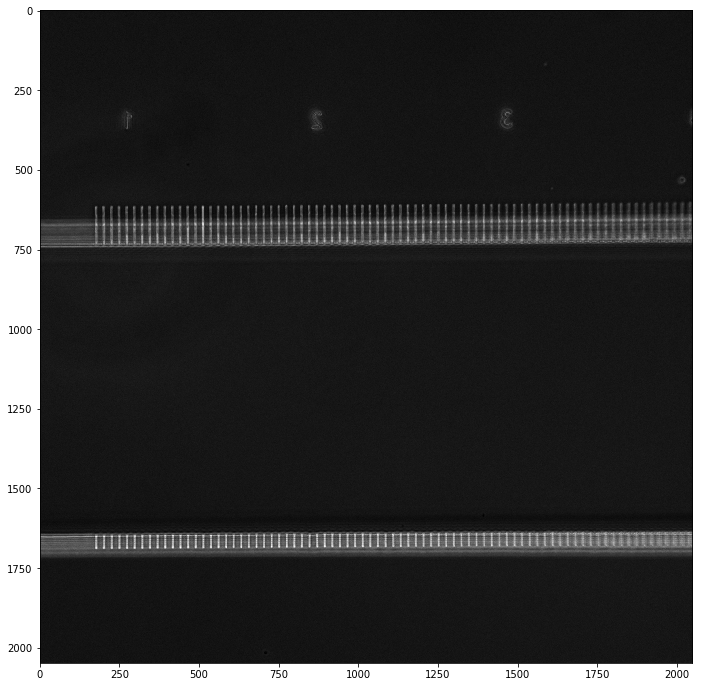

In [22]:
Ti5.liveview()

In [9]:
test_grid = Ti5.set_grid(44,3)

In [25]:
len(test_grid)

132

In [21]:
Ti5.mmc.setXYPosition(test_grid[0][0],test_grid[0][1])

In [9]:
for t in range(10):
    Ti5.multipoint_aq(test_grid,["BF","RFP","Cy5","Cy7"],t,output_folder="C:/Users/System 4/Documents/test_output/")

In [ ]:
    def liveview(self,img_size=(12,12),low=None,high=None):#W,interval=0.5):
        while True:
            try:
                while self.mmc.deviceBusy(self.camera_name):
                    time.sleep(0.005)
                    
                im1 = self.snap_image()
                clear_output(wait = True)
                plt.figure(figsize=img_size)
                if low == None or high == None:
                    plt.imshow(im1, interpolation='None',cmap="gray")
                else:
                    plt.imshow(im1, interpolation='None',cmap="gray",vmin=low,vmax=high)
                plt.show()
            except KeyboardInterrupt:
                break
        while self.mmc.deviceBusy(self.camera_name):
            time.sleep(0.01)

In [23]:
from time import sleep
import h5py

class FISH_scheduler:
    def __init__(self,handlerInstance,scopeInstance,fast_speed=2000,medium_speed=300,slow_speed=100,\
                 mins_fast_speed=4.,mins_medium_speed=5.,channels=["BF","RFP","Cy5","Cy7"],\
                output_folder="./"):
        self.handlerInstance = handlerInstance
        self.scopeInstance = scopeInstance
        self.fast_speed = fast_speed
        self.medium_speed = medium_speed
        self.slow_speed = slow_speed
        
        self.secs_fast_speed = int(mins_fast_speed*60)
        self.secs_medium_speed = int(mins_medium_speed*60)
        
        self.channels = channels
        self.output_folder = output_folder
        
    def wait_for(self,num_secs):
        for t in range(num_secs):
            sleep(1.)
            
    def load_reagent(self,reagent_name):
        print reagent_name
        
        self.handlerInstance.set_pump_state(0)
        self.handlerInstance.set_valve_state(reagent_name,1)
        self.handlerInstance.set_pump_state(self.fast_speed)
        
        self.wait_for(self.secs_fast_speed)
        
        self.handlerInstance.set_pump_state(self.medium_speed)
        self.handlerInstance.set_valve_state(reagent_name,0)
        
        self.wait_for(self.secs_medium_speed)
        
        return True
        
    def init_fixation(self):
        self.load_reagent("PFA(half-MeAc)")
        print "Initialized."
        
    def continue_fixation(self):
        self.load_reagent("EtOH(MeAc)")
        self.handlerInstance.set_pump_state(self.slow_speed)
        self.wait_for(45*60)
        self.load_reagent("PFA(half-MeAc)")
        print "Fixed."
        
    def perform_cycle(self,cycle_num,no_cleave=False):
        reagent_name = "Probe " + str(cycle_num)
        
        if not no_cleave:
            self.load_reagent("Cleave")
            self.wait_for(10*60)
            
        self.load_reagent("SSC")
        self.load_reagent(reagent_name)
        self.wait_for(15*60)
        self.load_reagent("Image")
        self.wait_for(5*60)
        self.handlerInstance.set_pump_state(self.slow_speed)        
        
    def run(self,grid_coords,num_cycles=8):
        first_x,first_y = grid_coords[0]
        self.scopeInstance.mmc.setXYPosition(first_x,first_y)
        
        img = self.scopeInstance.snap_image()
        
        with h5py.File(self.output_folder + "initial.hdf5","w") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset("data", data=img, chunks=(128,128), dtype='uint16')
        
        self.init_fixation()
        
        img = self.scopeInstance.snap_image()
        
        with h5py.File(self.output_folder + "init_fixation.hdf5","w") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset("data", data=img, chunks=(128,128), dtype='uint16')
        
        self.continue_fixation()
        
        img = self.scopeInstance.snap_image()
        
        with h5py.File(self.output_folder + "fixed.hdf5","w") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset("data", data=img, chunks=(128,128), dtype='uint16')
        
        for c in range(1,num_cycles+1):
            if c == 1:
                self.perform_cycle(c,no_cleave=True)
            else:
                self.perform_cycle(c)
            
            print "Imageing..."
            
            self.scopeInstance.multipoint_aq(grid_coords,self.channels,c,output_folder=self.output_folder)

In [ ]:
E:\Daniel\FISH_barcoding_project\2020-01-31_Auto_FISH_test

In [24]:
fish = FISH_scheduler(handler_1,Ti5,fast_speed=2000,medium_speed=300,slow_speed=100,\
                      mins_fast_speed=4.,mins_medium_speed=5.,channels=["BF","RFP","Cy5","Cy7"],output_folder="E:/Daniel/FISH_barcoding_project/2020-01-31_Auto_FISH_test/")

In [26]:
fish.run(test_grid,num_cycles=8)

PFA(half-MeAc)
[0,1,1,9,0];0;0
[0,1,1,9,0];1;0
[0,1,1,9,0];1;2000
[0,1,1,9,0];1;300
[0,1,1,9,0];0;300
Initialized.
EtOH(MeAc)
[0,1,1,9,0];0;0
[0,1,1,10,0];1;0
[0,1,1,10,0];1;2000
[0,1,1,10,0];1;300
[0,1,1,10,0];0;300
[0,1,1,10,0];0;100
PFA(half-MeAc)
[0,1,1,10,0];0;0
[0,1,1,9,0];1;0
[0,1,1,9,0];1;2000
[0,1,1,9,0];1;300
[0,1,1,9,0];0;300
Fixed.
SSC
[0,1,1,9,0];0;0
[0,1,1,8,0];1;0
[0,1,1,8,0];1;2000
[0,1,1,8,0];1;300
[0,1,1,8,0];0;300
Probe 1
[0,1,1,8,0];0;0
[0,2,1,12,0];1;0
[0,2,1,12,0];1;2000
[0,2,1,12,0];1;300
[0,2,1,12,0];0;300
Image
[0,2,1,12,0];0;0
[0,1,1,11,0];1;0
[0,1,1,11,0];1;2000
[0,1,1,11,0];1;300
[0,1,1,11,0];0;300
[0,1,1,11,0];0;100
Imageing...
Cleave
[0,1,1,11,0];0;0
[0,1,1,12,0];1;0
[0,1,1,12,0];1;2000
[0,1,1,12,0];1;300
[0,1,1,12,0];0;300
SSC
[0,1,1,12,0];0;0
[0,1,1,8,0];1;0
[0,1,1,8,0];1;2000
[0,1,1,8,0];1;300
[0,1,1,8,0];0;300
Probe 2
[0,1,1,8,0];0;0
[0,3,1,12,0];1;0
[0,3,1,12,0];1;2000
[0,3,1,12,0];1;300
[0,3,1,12,0];0;300
Image
[0,3,1,12,0];0;0
[0,1,1,11,0];1;0
[0,1,

In [1]:
from pylab import *
ion()

import numpy as np
import matplotlib
import MMCorePy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline  

### Init Nikon
 - make sure the scope is not escaped

In [2]:
mmc = MMCorePy.CMMCore()

In [3]:
mmc.loadSystemConfiguration("./MMMain.cfg")

In [4]:
mmc.setPrimaryLogFile("./presets/log.txt")

### Snap and plot an image

In [5]:
mmc.getLoadedDevices()

('DigitalIO',
 'FW_Empty_S1',
 'FW_FITC_S2',
 'FW_TRITC_S3',
 'FW_CFP_S4',
 'FW_YFPHQ_S5',
 'FW_TxRed_S6',
 'CoolLED',
 'SpectraIII_395nm',
 'SpectraIII_438nm',
 'SpectraIII_475nm',
 'SpectraIII_511nm',
 'SpectraIII_555nm',
 'SpectraIII_575nm',
 'SpectraIII_635nm',
 'SpectraIII_748nm',
 'Ti2',
 'ZDrive',
 'XYStage',
 'Nosepiece',
 'FilterTurret1',
 'Turret1Shutter',
 'LightPath',
 'PFS',
 'PFSOffset',
 'IntermediateMagnification',
 'SpectraIII',
 'BSI Prime',
 'Core')

### Live View

In [5]:
def liveview(camera,img_size=(12,12),low=None,high=None):#W,interval=0.5):
    mmc.setCameraDevice(camera)
    while True:
        try:
            while mmc.deviceBusy(camera):
                time.sleep(0.005)
            mmc.snapImage()
            im1 = mmc.getImage()
            clear_output(wait = True)
            plt.figure(figsize=img_size)
            if low == None or high == None:
                plt.imshow(im1, interpolation='None',cmap="gray")
            else:
                plt.imshow(im1, interpolation='None',cmap="gray",vmin=low,vmax=high)
            plt.show()
        except KeyboardInterrupt:
            break
    while mmc.deviceBusy(camera):
        time.sleep(0.01)
#         slp = interval - (time.time() - ti)
#         time.sleep(slp)

In [31]:
mmc.setShutterOpen("SpectraIII",False)

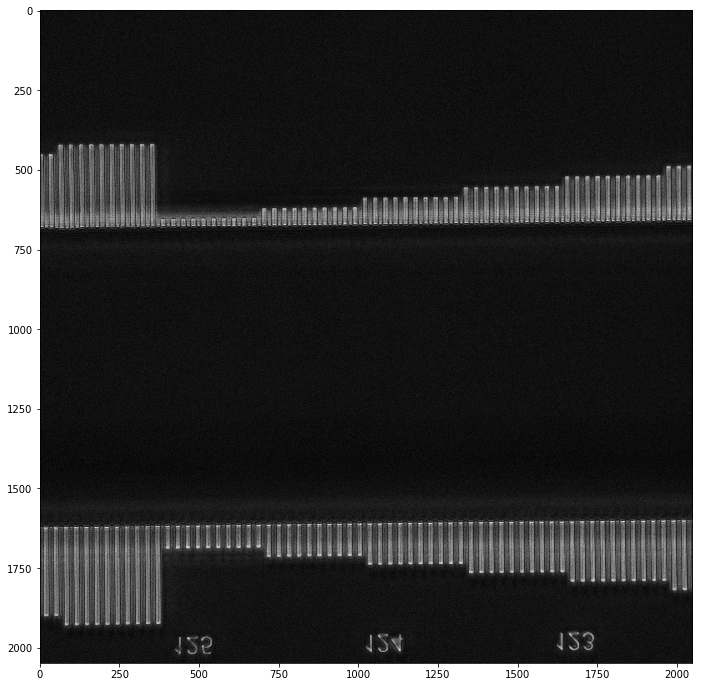

In [10]:
liveview("BSI Prime",low=None,high=None)

### Snap and Contrast

In [9]:
def snap_image(camera,img_size=(12,12)):
    mmc.setCameraDevice(camera)
    mmc.snapImage()
    im1 = mmc.getImage()
    return im1

def auto_contrast(img,low_percentile=0,high_percentile=100):
    low = np.percentile(img,low_percentile)
    high = np.percentile(img,high_percentile)
    return low,high

def plot_img(img,low,high,img_size=(12,12)):
    clear_output(wait = True)
    plt.figure(figsize=img_size)
    plt.imshow(im1, interpolation='None',vmin=low,vmax=high)
    plt.show()

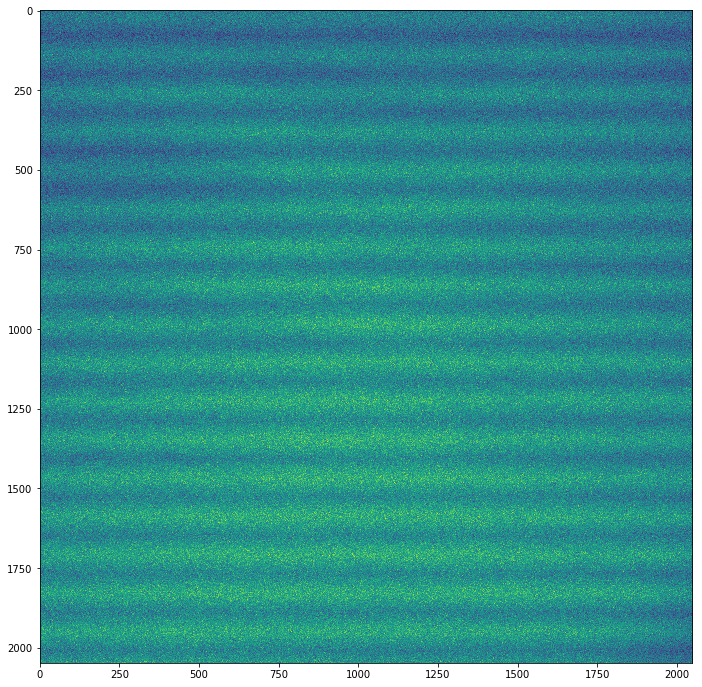

In [10]:
im1 = snap_image("BSI Prime")
low,high = auto_contrast(im1)
plot_img(im1,low,high)

### Imaging Parameters

In [11]:
mmc.getDevicePropertyNames('BSI Prime')

('AcquisitionMethod',
 'ActualInterval-ms',
 'Binning',
 'CCDTemperature',
 'CCDTemperatureSetPoint',
 'ChipName',
 'CircularBufferAutoSize',
 'CircularBufferEnabled',
 'CircularBufferFrameCount',
 'CircularBufferFrameRecovery',
 'ClearCycles',
 'ClearMode',
 'Color',
 'Description',
 'ExposeOutMode',
 'Exposure',
 'FTCapable',
 'FanSpeedSetpoint',
 'FirmwareVersion',
 'FullWellCapacity',
 'Gain',
 'MetadataEnabled',
 'Name',
 'Offset',
 'PMode',
 'PP  0 DESPECKLE BRIGHT LOW',
 'PP  1   ENABLED',
 'PP  1   THRESHOLD',
 'PP  1 DESPECKLE BRIGHT HIGH',
 'PP  2   ENABLED',
 'PP  2   MIN ADU AFFECTED',
 'PP  2   THRESHOLD',
 'PP  2 DESPECKLE DARK LOW',
 'PP  3   ENABLED',
 'PP  3   THRESHOLD',
 'PP  3 DESPECKLE DARK HIGH',
 'PP  4   ENABLED',
 'PP  4   MIN ADU AFFECTED',
 'PP  4   THRESHOLD',
 'PP  4 DENOISING',
 'PP  5   ENABLED',
 'PP  5   GAIN',
 'PP  5   LAMBDA',
 'PP  5   NO OF ITERATIONS',
 'PP  5   OFFSET',
 'PP  5 QUANTVIEW',
 'PP  6   ENABLED',
 'PP  7 Reset',
 'PVCAM Adapter Versi

In [12]:
mmc.getProperty('BSI Prime',"Exposure")

'10.0000'

#### Exposure

In [14]:
mmc.setExposure("BSI Prime",200.)

In [15]:
mmc.getExposure("BSI Prime")

200.0

#### Binning

In [17]:
mmc.getAllowedPropertyValues("BSI Prime","Binning")

('1x1', '2x2')

In [18]:
mmc.setProperty("BSI Prime","Binning","1x1")

In [19]:
mmc.getProperty("BSI Prime","Binning")

'1x1'

#### metadata?

In [20]:
mmc.getAllowedPropertyValues("BSI Prime","MetadataEnabled")

('No', 'Yes')

In [21]:
mmc.getProperty("BSI Prime","MetadataEnabled")

'No'

In [ ]:
mmc.snapImage()

In [ ]:
test = mmc.getImage()

### Shutter

#### Changing SpectraIII Shutter

In [22]:
mmc.setShutterOpen("SpectraIII",False)

#### Changing Epi1 Shutter

In [25]:
mmc.setShutterOpen("Turret1Shutter",True)

### Turret

In [26]:
mmc.getDevicePropertyNames('FilterTurret1')

('Label', 'State')

In [27]:
mmc.getAllowedPropertyValues('FilterTurret1','Label')

('1-Quad', '2-QUAD-IR', '3-DAPI', '4-Cy5', '5-Cy7', '6-Empty')

In [28]:
mmc.getAllowedPropertyValues('FilterTurret1','State')

('0', '1', '2', '3', '4', '5')

In [30]:
mmc.setProperty('FilterTurret1','State','2')

In [31]:
mmc.getProperty('FilterTurret1','Label')

'3-DAPI'

In [32]:
mmc.getProperty('FilterTurret1','State')

'2'

### Emission Wheel

In [33]:
def set_filter_wheel(mmc,state_idx):
    filter_wheel_states = ["FW_Empty_S1","FW_FITC_S2","FW_TRITC_S3",\
                      "FW_CFP_S4","FW_YFPHQ_S5","FW_TxRed_S6"]
    all_states = set(range(6))
    off_states = list(all_states-set([state_idx]))
    for i in off_states:
        mmc.setProperty(filter_wheel_states[i],'Volts',0.)
    mmc.setProperty(filter_wheel_states[state_idx],'Volts',5.)

In [35]:
set_filter_wheel(mmc,2)

### Spectra III

In [36]:
mmc.getDevicePropertyNames('SpectraIII')

('BLUE',
 'BLUE_Intensity',
 'CYAN',
 'CYAN_Intensity',
 'Connection',
 'Description',
 'FirmwareVersion',
 'GREEN',
 'GREEN_Intensity',
 'LEModel',
 'Model',
 'NIR',
 'NIR_Intensity',
 'Name',
 'RED',
 'RED_Intensity',
 'SerialNumber',
 'State',
 'TEAL',
 'TEAL_Intensity',
 'VIOLET',
 'VIOLET_Intensity',
 'YELLOW',
 'YELLOW_Intensity')

In [37]:
channels = ['VIOLET','BLUE','CYAN','TEAL','GREEN','YELLOW','RED','NIR']
for channel in channels:
    channel_int = channel + "_Intensity"
    print(mmc.getProperty("SpectraIII",channel_int))

0
0
0
0
0
0
0
0


In [38]:
mmc.setProperty("SpectraIII","RED","0")

In [39]:
mmc.getProperty("SpectraIII","RED")

'0'

In [40]:
mmc.setProperty("SpectraIII","RED_Intensity","0")

In [41]:
mmc.getProperty("SpectraIII","RED_Intensity")

'0'

### Nosepiece

In [42]:
mmc.getDevicePropertyNames('Nosepiece')

('Label', 'State')

In [43]:
mmc.getAllowedPropertyValues('Nosepiece','Label')

('1-Plan Apo Lmbd 20x',
 '2-Plan Apo Lmbd 40x',
 '3-Plan Apo Lmbd 40x',
 '4-',
 '5-Plan Apo Lmbd 60x Oil',
 '6-Plan Fluor 100x Oil')

In [44]:
mmc.getAllowedPropertyValues('Nosepiece','State')

('0', '1', '2', '3', '4', '5')

In [45]:
mmc.setProperty('Nosepiece','State','2')

In [46]:
mmc.getProperty('Nosepiece','Label')

'3-Plan Apo Lmbd 40x'

### XYStage

In [47]:
mmc.getXYStageDevice()

'XYStage'

In [48]:
mmc.getXYPosition()

[5557.400000000001, -399.40000000000003]

In [49]:
mmc.deviceBusy("XYStage")

False

#### Example grid loop

In [50]:
x_ori,y_ori = mmc.getXYPosition()
for x in range(0,2000,500):
    for y in range(0,2000,500):
        while mmc.deviceBusy("XYStage"):
            time.sleep(0.1)
            pass
        mmc.setXYPosition(x_ori+x,y_ori+y)

### ZStage

In [9]:
mmc.getPosition()

5600.46

In [6]:
mmc.getFocusDirection("ZDrive")

1

In [10]:
mmc.setRelativePosition("ZDrive",-5000.)

In [11]:
mmc.getFocusDirection("ZDrive")

1

In [8]:
mmc.getFocusDevice()

'ZDrive'

### PFS

In [12]:
mmc.getDevicePropertyNames('PFS')

('DichroicMirrorInserted', 'FocusMaintenance', 'LEDIntensity')

In [13]:
mmc.getAllowedPropertyValues('PFS','FocusMaintenance')

('Off', 'On')

In [15]:
mmc.setProperty('PFS','FocusMaintenance','Off')

In [ ]:
mmc.getProperty('PFS','FocusMaintenance')

In [ ]:
mmc.deviceBusy("PFS")

### PFS Offset

In [110]:
mmc.getFocusDirection("PFSOffset")

1

In [109]:
mmc.setRelativePosition("PFSOffset",1.)

### Cool LED

In [ ]:
mmc.getDevicePropertyNames('CoolLED')

In [ ]:
mmc.setProperty('CoolLED','Volts','0')

In [ ]:
mmc.getProperty('CoolLED','Volts')

### Testing Multichannel

In [23]:
mmc.setConfig("FISH_channels","RFP")

In [17]:
mmc.setConfig("FISH_channels","Cy5")

In [23]:
mmc.setConfig("FISH_channels","Cy7")

In [25]:
mmc.setShutterOpen("SpectraIII",False)

In [11]:
def set_grid(num_col,num_row,col_step=333.,row_step=686.):
    grid_coords = []
    
    x_ori,y_ori = mmc.getXYPosition()
    start_left = True
    
    for row in range(num_row):
        y_disp = row*row_step
    
        if start_left:
            for col in range(num_col):
                x_disp = col*(-col_step)
                current_coord = (x_ori+x_disp,y_ori+y_disp)
                grid_coords.append(current_coord)
            start_left = False
        else:
            for col in range(num_col):
                x_disp = (num_col-col-1)*(-col_step)
                current_coord = (x_ori+x_disp,y_ori+y_disp)
                grid_coords.append(current_coord)
            start_left = True
            
    return grid_coords

In [12]:
test_grid = set_grid(10,3)

In [40]:
test_grid[0]

(6322.900000000001, 2967.4)

In [14]:
mmc.setXYPosition(test_grid[0][0],test_grid[0][1])

In [15]:
import numpy as np

channels = ["BF","RFP","Cy5","Cy7"]
all_imgs = []

for x_coord,y_coord in test_grid:
    while mmc.deviceBusy("XYStage"):
        time.sleep(0.1)
        pass
    mmc.setXYPosition(x_coord,y_coord)

    imgs = []
    for channel in channels:
        while mmc.systemBusy():
            time.sleep(0.1)
            pass
        mmc.setConfig("FISH_channels",channel)
        while mmc.systemBusy():
            time.sleep(0.1)
            pass
        mmc.setExposure("BSI Prime",30.)
        mmc.setShutterOpen("SpectraIII",True)
        mmc.snapImage()
        mmc.setShutterOpen("SpectraIII",False)
        img = mmc.getImage()
        imgs.append(img)

    all_imgs.append(imgs)
all_imgs = np.array(all_imgs)

In [9]:
all_imgs[0]

array([[[366, 338, 313, ..., 277, 272, 278],
        [324, 321, 285, ..., 244, 297, 268],
        [333, 286, 261, ..., 280, 264, 311],
        ...,
        [246, 293, 295, ..., 310, 293, 253],
        [271, 272, 293, ..., 260, 299, 298],
        [263, 255, 296, ..., 260, 270, 250]]], dtype=uint16)

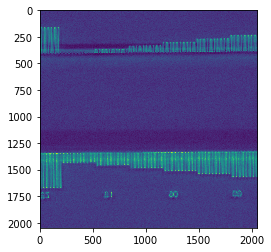

In [38]:
from matplotlib import pyplot as plt

plt.imshow(all_imgs[,0])

In [57]:
import serial
import serial.tools.list_ports
import time
from time import sleep

In [58]:
class arduino:
    def __init__(self,handshakes=2):
        self.valvestate = 0
        self.pumpstate = 0
        self.titanxstates = [0 for i in range(5)]
        self.handshakes = handshakes
        self.titanx_states = {"Probe 1" : [0,2,1,12,0],"Probe 2": [0,3,1,12,0],"Probe 3": [0,4,1,12,0],\
                        "Probe 4": [0,5,1,12,0],"Probe 5": [0,6,1,12,0],"Probe 6" : [0,7,1,12,0],\
                        "Probe 7" : [0,8,1,12,0],"Probe 8" : [0,9,1,12,0],"Probe 9" : [0,10,1,12,0],\
                        "Probe 10" : [0,11,1,12,0],"Probe 11" : [0,12,1,12,0],"Probe 12" : [0,1,2,12,0],\
                        "Probe 13" : [0,1,3,12,0],"Probe 14" : [0,1,4,12,0],"Probe 15" : [0,1,5,12,0],\
                       "Probe 16" : [0,1,6,12,0],"Probe 17" : [0,1,7,12,0],"Probe 18" : [0,1,8,12,0],\
                        "Probe 19" : [0,1,9,12,0],"Probe 20" : [0,1,10,12,0],"Probe 21" : [0,1,11,12,0],\
                        "Probe 22" : [0,1,12,12,0],"Probe 23" : [0,1,1,1,0],"Probe 24" : [0,1,1,2,0],\
                        "SSC" : [0,1,1,8,0],"PFA" : [0,1,1,9,0],"EtOH" : [0,1,1,10,0],"Image" : [0,1,1,11,0],\
                        "Cleave" : [0,1,1,12,0]}
        
    def get_heartbeat(self,comport,connect_code="MARLIN",timeout=10.):
        try:
            ti = time.time()
            no_timeout = True
            s = serial.Serial(comport,9600,timeout=0.5)
            readcmd = "5\n".encode('ascii')
            while no_timeout:
                s.write(readcmd)
                returnedstr = s.read_until()
                t_elapsed = time.time() - ti                    
                if len(returnedstr) > 0:
                    no_timeout = False
                elif t_elapsed>timeout:
                    no_timeout = False
            s.close()
            if returnedstr == "MARLIN":
                return True
            else:
                return False
        except (OSError, serial.SerialException):
            return False 
        
    def connect(self,connect_code="MARLIN",timeout=10.):
        ports = ['COM%s' % (i + 1) for i in range(256)]
        result = []
        for port in ports:
            heartbeat = self.get_heartbeat(port,connect_code=connect_code,timeout=timeout)
            if heartbeat:
                result.append(port)
        if len(result) == 0:
            raise ValueError("No MARLIN detected.")
        elif len(result) == 1:
            ti = time.time()
            no_timeout = True
            self.serial_handle = serial.Serial(result[0], 9600, timeout=0.5)
            readcmd = "5\n".encode('ascii')
            while no_timeout:
                self.serial_handle.write(readcmd)
                returnedstr = self.serial_handle.read_until()
                t_elapsed = time.time() - ti
                if len(returnedstr) > 0:
                    no_timeout = False
                elif t_elapsed>timeout:
                    no_timeout = False
            if returnedstr == "MARLIN":
                self.serial_handle.timeout = 10.
                print("Connected.")
            else:
                raise ValueError("MARLIN connection timeout.")
        else:
            raise ValueError("More than one MARLIN detected.")
        
        
    def updatestate(self,valvestate,pumpstate,titanxstates):
        self.valvestate = valvestate
        self.pumpstate = pumpstate
        self.titanxstates = titanxstates
        
    def sendstate(self,valvestate,pumpstate,titanxstates):## Note need to rewrite arduino code for handshake using
    # newlines
        self.updatestate(valvestate,pumpstate,titanxstates)
        no_handshake = True
        handshake_failed = False
        handshake_attempts = 0

        while no_handshake:
            valvestr = "4" + str(self.valvestate)
            pumpstr = str(self.pumpstate)
            pumpstr = "3" + ("0"*(4-len(pumpstr)) + pumpstr)

            titanxstrlist = []

            for titannum,titanxstate in enumerate(self.titanxstates):
                if titanxstate != 0:
                    titanxstr = str(titanxstate)
                    titanxstr = "2" + str(titannum) + ("0"*(2-len(titanxstr)) + titanxstr)
                    titanxstrlist.append(titanxstr)

            cmdlist = [""] + [valvestr] + [pumpstr] + titanxstrlist

            for cmd in cmdlist:
                sendstr = cmd + '\n'
                statestr = sendstr.encode('ascii')
                self.serial_handle.write(statestr)
                time.sleep(0.25)

            readcmd = "0\n".encode('ascii')
            self.serial_handle.write(readcmd)
            returnedstr = self.serial_handle.read_until()[:-1]
            self.serial_handle.reset_output_buffer()
            self.serial_handle.reset_input_buffer()
            checkstr = "[" + ",".join([str(state) for state in self.titanxstates]) + "];" + str(self.valvestate) + ";" + str(self.pumpstate)
            
            ###OVERRIDE FOR TESTING###
            
#             no_handshake = False
#             print checkstr.strip()
            print returnedstr.strip()
            
            if returnedstr.strip() == checkstr.strip():
                no_handshake = False
            handshake_attempts += 1
            if handshake_attempts >= self.handshakes:
                raise Exception("Handshake failed.")

    def set_valve_state(self,titanx_state_name,valvestate):
        titanxstates = self.titanx_states[titanx_state_name]
        self.sendstate(valvestate,self.pumpstate,titanxstates)
    
    def set_pump_state(self,pumpstate):
        self.sendstate(self.valvestate,pumpstate,self.titanxstates)
        
        

In [28]:
ard = arduino()

NameError: name 'arduino' is not defined

In [60]:
ard.connect()

Connected.


In [68]:
ard.set_valve_state("PFA",1)

[0,1,1,9,0];1;0


In [67]:
ard.set_pump_state(0)

[0,1,1,10,0];1;0


In [30]:
#cleaning
for state_name,_ in handler_1.titanx_states.items():
    handler_1.set_pump_state(0)
    handler_1.set_valve_state(state_name,0)
    handler_1.set_pump_state(2000)
    sleep(90.)
handle.set_pump_state(0)
handler_1.set_valve_state("Image",1)
handler_1.set_pump_state(2000)
sleep(5.*60.)
handler_1.set_pump_state(0)
handler_1.set_valve_state("Image",0)

[0,1,1,11,0];0;0
[0,10,1,12,0];0;0
[0,10,1,12,0];0;2000
[0,10,1,12,0];0;0
[0,9,1,12,0];0;0
[0,9,1,12,0];0;2000
[0,9,1,12,0];0;0
[0,2,1,12,0];0;0
[0,2,1,12,0];0;2000
[0,2,1,12,0];0;0
[0,4,1,12,0];0;0
[0,4,1,12,0];0;2000
[0,4,1,12,0];0;0
[0,3,1,12,0];0;0
[0,3,1,12,0];0;2000
[0,3,1,12,0];0;0
[0,6,1,12,0];0;0
[0,6,1,12,0];0;2000
[0,6,1,12,0];0;0
[0,5,1,12,0];0;0
[0,5,1,12,0];0;2000
[0,5,1,12,0];0;0
[0,8,1,12,0];0;0
[0,8,1,12,0];0;2000
[0,8,1,12,0];0;0
[0,7,1,12,0];0;0
[0,7,1,12,0];0;2000
[0,7,1,12,0];0;0
[0,1,1,2,0];0;0
[0,1,1,2,0];0;2000
[0,1,1,2,0];0;0
[0,1,10,12,0];0;0
[0,1,10,12,0];0;2000
[0,1,10,12,0];0;0
[0,1,11,12,0];0;0
[0,1,11,12,0];0;2000
[0,1,11,12,0];0;0
[0,1,12,12,0];0;0
[0,1,12,12,0];0;2000
[0,1,12,12,0];0;0
[0,1,1,1,0];0;0
[0,1,1,1,0];0;2000
[0,1,1,1,0];0;0
[0,1,1,9,0];0;0
[0,1,1,9,0];0;2000
[0,1,1,9,0];0;0
[0,1,1,12,0];0;0
[0,1,1,12,0];0;2000
[0,1,1,12,0];0;0
[0,1,1,10,0];0;0
[0,1,1,10,0];0;2000
[0,1,1,10,0];0;0
[0,1,5,12,0];0;0
[0,1,5,12,0];0;2000
[0,1,5,12,0];0;0
[0,1,4,1

NameError: name 'handle' is not defined

In [66]:
import numpy as np

channels = ["BF","RFP","Cy5","Cy7"]
all_imgs = []

for x_coord,y_coord in test_grid:
    while mmc.deviceBusy("XYStage"):
        time.sleep(0.1)
        pass
    mmc.setXYPosition(x_coord,y_coord)

    imgs = []
    for channel in channels:
        while mmc.systemBusy():
            time.sleep(0.1)
            pass
        mmc.setConfig("FISH_channels",channel)
        while mmc.systemBusy():
            time.sleep(0.1)
            pass
        mmc.setExposure("BSI Prime",30.)
        mmc.setShutterOpen("SpectraIII",True)
        mmc.snapImage()
        mmc.setShutterOpen("SpectraIII",False)
        img = mmc.getImage()
        imgs.append(img)

    all_imgs.append(imgs)
all_imgs = np.array(all_imgs)

In [4]:
import pandas as pd

In [7]:
import xml.etree.ElementTree as ET
import xmltodict
import json

tree = ET.parse('multipoints_this_is_just_a_test.xml')
xml_data = tree.getroot()

xmlstr = ET.tostring(xml_data, encoding='utf8', method='xml')


data_dict = dict(xmltodict.parse(xmlstr))

with open('new_data_2.json', 'w+') as json_file:
    json.dump(data_dict, json_file, indent=4, sort_keys=True)

KeyError: 0